# Convolutional Neural Networks

## Project: Write an Algorithm for Landmark Classification


### Introduction

The project folder has the following structure:

* In the main directory you have this notebook, `cnn_from_scratch.ipynb`, that contains the instruction and some questions you will have to answer. Follow this notebook and complete the required sections in order.

* In the `src/` directory you have several source files. As instructed in this notebook, you will open and complete those files, then come back to this notebook to execute some tests that will verify what you have done. While these tests don't guarantee that your work is bug-free, they will help you finding the most obvious problems so you will be able to proceed to the next step with confidence.

* Sometimes you will need to restart the notebook. If you do so, remember to execute also the cells containing the code you have already completed starting from the top, before you move on.

> <img src="static_images/icons/noun-info-2558213.png" alt="?" style="width:25px"/> Once you have completed all the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to HTML, all the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. If you are using Jupyter Lab, you can use **File -> Export Notebook as -> Export Notebook to HTML**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

> <img src="static_images/icons/noun-info-2558213.png" alt="?" style="width:25px"/> Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.

### Designing and training a CNN from scratch

In this notebook, you will create a CNN that classifies landmarks.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 50%.

Although 50% may seem low at first glance, it seems more reasonable after realizing how difficult of a problem this is. Many times, an image that is taken at a landmark captures a fairly mundane image of an animal or plant, like in the following picture.

<img src="static_images/train/00.Haleakala_National_Park/084c2aa50d0a9249.jpg" alt="Bird in Haleakalā National Park" style="width: 400px;"/>

Just by looking at that image alone, would you have been able to guess that it was taken at the Haleakalā National Park in Hawaii?

An accuracy of 50% is significantly better than random guessing, which would provide an accuracy of just 2% (100% / 50 classes). In Step 2 of this notebook, you will have the opportunity to greatly improve accuracy by using transfer learning to create a CNN.

Experiment with different architectures, hyperparameters, training strategies, and trust your intuition.  And, of course, have fun!

---
## <img src="static_images/icons/noun-advance-2109145.png" alt=">" style="width:50px"/> Step 0: Setting up

The following cells make sure that your environment is setup correctly, download the data if you don't have it already, and also check that your GPU is available and ready to go. You have to execute them every time you restart your notebook.

In [1]:
# Run the installation and setup environment steps
!pip install opencv-python-headless matplotlib numpy pillow bokeh torch torchvision tqdm ipywidgets livelossplot pytest pandas seaborn

In [2]:
from src.helpers import setup_env

# If running locally, this will download dataset (make sure you have at
# least 2 Gb of space on your hard drive)
setup_env()

GPU available
Dataset already downloaded. If you need to re-download, please delete the directory landmark_images
Reusing cached mean and std


In [3]:
!pytest -vv src/data.py -k data_loaders

============================= test session starts ==============================
platform linux -- Python 3.9.19, pytest-8.2.2, pluggy-1.5.0 -- /home/studio-lab-user/.conda/envs/default/bin/python3.9
cachedir: .pytest_cache
rootdir: /home/studio-lab-user/sagemaker-studiolab-notebooks/workspace/home/starter-kit
plugins: anyio-4.3.0
collected 4 items / 1 deselected / 3 selected                                  

src/data.py::test_data_loaders_keys PASSED                               [ 33%]
src/data.py::test_data_loaders_output_type PASSED                        [ 66%]
src/data.py::test_data_loaders_output_shape PASSED                       [100%]

======================= 3 passed, 1 deselected in 2.95s ========================


You should see something like:
```
src/data.py::test_data_loaders_keys PASSED                               [ 33%]
src/data.py::test_data_loaders_output_type PASSED                        [ 66%]
src/data.py::test_data_loaders_output_shape PASSED                       [100%]

======================= 3 passed, 1 deselected in 1.81s ========================
```
If all the tests are `PASSED`, you can move to the next section.

> <img src="static_images/icons/noun-info-2558213.png" alt="?" style="width:25px"/> **What to do if tests fail**
When a test fails, `pytest` will mark it as `FAILED` as opposed to `PASSED`, and will print a lot of useful output, including a message that should tell you what the problem is. For example, this is the output of a failed test:
> ```
>    def test_data_loaders_keys(data_loaders):
>    
>       assert set(data_loaders.keys()) == {"train", "valid", "test"}
E       AssertionError: assert {'tes', 'train', 'valid'} == {'test', 'train', 'valid'}
E         Extra items in the left set:
E         'tes'
E         Full diff:
E         - {'test', 'train', 'valid'}
E         + {'tes', 'train', 'valid'}
E         ?                          +++++++
>
> src/data.py:171: AssertionError
-------------- Captured stdout setup ----------------------------------------------
Reusing cached mean and std for landmark_images
Dataset mean: tensor([0.4638, 0.4725, 0.4687]), std: tensor([0.2699, 0.2706, 0.3018])
=========== short test summary info ===============================================
FAILED src/data.py::test_data_loaders_keys - AssertionError: The keys of the data_loaders dictionary should be train, valid and test
> ```
> In the `short test summary info` you can see a short description of the problem. In this case, the dictionary we are returning has the wrong keys. Going above a little, you can see that the test expects `{'test', 'train', 'valid'}` while we are returning `{'tes', 'train', 'valid'}` (there is a missing `t`). So we can go back to our function, fix that problem and test again.
>
> In other cases, you might get an error like:
> ```
    def _conv_forward(self, input: Tensor, weight: Tensor, bias: Optional[Tensor]):
        if self.padding_mode != 'zeros':
            return F.conv2d(F.pad(input, self._reversed_padding_repeated_twice, mode=self.padding_mode),
                            weight, bias, self.stride,
                            _pair(0), self.dilation, self.groups)
        return F.conv2d(input, weight, bias, self.stride,
>                       self.padding, self.dilation, self.groups)
E       RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
>
> ../../../../miniconda3/envs/udacity_starter/lib/python3.7/site-packages/torch/nn/modules/conv.py:440: RuntimeError
> ```
> Looking at the stack trace you should be able to understand what it is going on. In this case, we forgot to add a `.cuda()` to some tensor. For example, the model is on the GPU, but the data aren't.

<img src="static_images/icons/noun-question-mark-869751.png" alt="?" style="width:25px"/> **Question:** Describe your chosen procedure for preprocessing the data.
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?

### > Answer:

**Chosen Procedure for Preprocessing the Data**

#### Image Resizing

To preprocess the data, I adopted a two-stage resizing process:

1. **Resize to 256 Pixels**: Initially, each image was resized so that its smaller edge measured 256 pixels while maintaining the original aspect ratio. This step ensured uniformity in image size and provided sufficient resolution for further cropping.

2. **Center Crop to 224x224 Pixels**: Following the initial resizing, the images were center-cropped to a size of 224x224 pixels. This specific dimension (224x224) was selected because it is widely used in various convolutional neural network (CNN) architectures, including AlexNet, VGGNet, and ResNet. It strikes an effective balance between preserving important image details and keeping computational requirements manageable.

For the training dataset, an additional variation was introduced:

- **Random Resized Crop to 224x224 Pixels**: Instead of a fixed center crop, I applied a random resized crop to the training images. This method involved cropping a random portion of the image and resizing it to 224x224 pixels. This approach helped introduce variability in the training data, allowing the model to generalize better by learning to recognize objects in different contexts and scales.

#### Data Augmentation

To further enhance the variability and robustness of the model, I applied data augmentation techniques to the training dataset:

- **Random Horizontal Flip**: This augmentation randomly flipped the image horizontally with a probability of 0.5. It helped the model learn to recognize objects in different orientations, thereby improving its generalization capability.

- **Normalization**: Finally, all images were normalized using the mean and standard deviation calculated from the dataset. Normalization ensured consistent scaling of the input data, which is crucial for the stability and performance of the training process.

For the validation and test datasets, I maintained a consistent approach with minimal transformations to ensure unbiased evaluation:

- **Resizing, Center Cropping, and Normalization**: Only resizing, center cropping, and normalization were applied to the validation and test datasets. No data augmentation was used for these datasets to ensure that the evaluation metrics accurately reflected the model's performance on real-world, unaltered data.

**Summary**

- **Training Data**:
  - Resize to 256 pixels, random resized crop to 224x224 pixels
  - Augmentation: Random horizontal flip
  - Normalization

- **Validation and Test Data**:
  - Resize to 256 pixels, center crop to 224x224 pixels
  - Normalization

This preprocessing pipeline ensured that the model received images of consistent size and scale, while benefiting from the variability introduced by data augmentation during training. This approach contributed to the model's improved generalization to new data and enhanced overall performance.

### Visualize a Batch of Training Data

Go back to `src/data.py` and complete the function `visualize_one_batch` in all places with the `YOUR CODE HERE` marker. After you're done, execute the following cell and make sure the test `src/data.py::test_visualize_one_batch` is `PASSED`:

In [4]:
!pytest -vv src/data.py -k visualize_one_batch

============================= test session starts ==============================
platform linux -- Python 3.9.19, pytest-8.2.2, pluggy-1.5.0 -- /home/studio-lab-user/.conda/envs/default/bin/python3.9
cachedir: .pytest_cache
rootdir: /home/studio-lab-user/sagemaker-studiolab-notebooks/workspace/home/starter-kit
plugins: anyio-4.3.0
collected 4 items / 3 deselected / 1 selected                                  

src/data.py::test_visualize_one_batch PASSED                             [100%]

======================= 1 passed, 3 deselected in 2.94s ========================


We can now use the code we just completed to get a batch of images from your train data loader and look at them.

Visualizing the output of your data loader is a great way to ensure that your data loading and preprocessing (including transforms such as rotations, translations, color transforms...) are working as expected.

Reusing cached mean and std
Dataset mean: tensor([0.4638, 0.4725, 0.4687]), std: tensor([0.2697, 0.2706, 0.3017])
Reusing cached mean and std


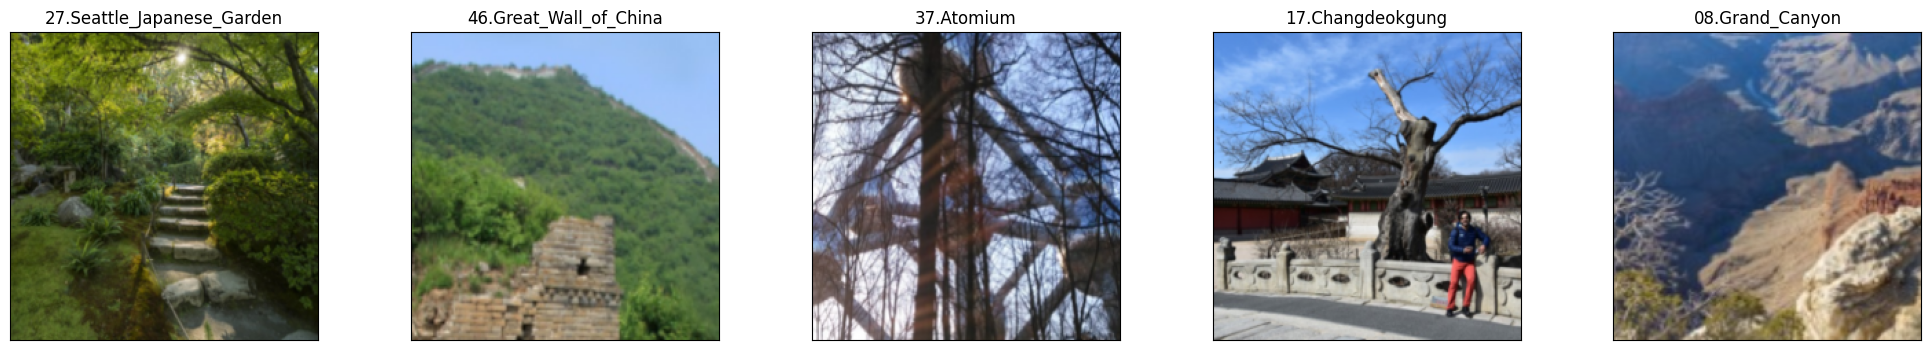

In [5]:
%matplotlib inline
from src.data import visualize_one_batch, get_data_loaders

# use get_data_loaders to get the data_loaders dictionary. Use a batch_size
# of 5, a validation size of 0.01 and num_workers=-1 (all CPUs)
data_loaders = get_data_loaders(batch_size=5, valid_size=0.01, num_workers=-1)

visualize_one_batch(data_loaders)

---
## <img src="static_images/icons/noun-advance-2109145.png" alt=">" style="width:50px"/> Step 2: Define model

Open `src/model.py` and complete the `MyModel` class filling in all the `YOUR CODE HERE` sections. After you're done, execute the following test and make sure it passes:

In [6]:
!pytest -vv src/model.py

============================= test session starts ==============================
platform linux -- Python 3.9.19, pytest-8.2.2, pluggy-1.5.0 -- /home/studio-lab-user/.conda/envs/default/bin/python3.9
cachedir: .pytest_cache
rootdir: /home/studio-lab-user/sagemaker-studiolab-notebooks/workspace/home/starter-kit
plugins: anyio-4.3.0
collected 1 item                                                               

src/model.py::test_model_construction PASSED                             [100%]

============================== 1 passed in 3.04s ===============================


<img src="static_images/icons/noun-question-mark-869751.png" alt="?" style="width:25px"/> **Question**: Outline the steps you took to get to your final CNN architecture and your reasoning at each step.

#### > Answer
In designing the CNN architecture for our project, I followed a systematic approach, considering various factors and making informed decisions at each step.

1. **Research and Understanding:** Initially, I conducted thorough research on existing CNN architectures and their applications in similar projects. This helped me understand the common practices and architectures used in image classification tasks.

2. **Start Simple:** I began by designing a simple CNN architecture with a few convolutional layers followed by max-pooling layers. This basic architecture served as a starting point to establish a working model and understand the baseline performance.

3. **Experimentation with Layer Depth:** I experimented with different depths of convolutional layers to find the optimal balance between model complexity and performance. Adding more layers increased the model's capacity to learn intricate features but also risked overfitting.

4. **Adjusting Kernel Sizes and Strides:** I fine-tuned the kernel sizes and strides of the convolutional layers to control the receptive field and the amount of spatial information captured by each layer. This adjustment helped in capturing both local and global features efficiently.

5. **Introduction of Dropout:** To prevent overfitting and improve generalization, I introduced dropout layers after certain convolutional layers. This regularization technique randomly drops a fraction of the neurons during training, forcing the model to learn more robust features.

6. **Pooling Strategy:** I experimented with different pooling strategies, such as max-pooling and average pooling, to downsample the feature maps and reduce computational complexity. Max-pooling proved to be more effective in retaining important features.

7. **Output Layer Design:** For the output layer, I used a fully connected layer followed by a softmax activation function to predict the probabilities of each class. The number of output units was determined by the number of classes in our dataset.

8. **Hyperparameter Tuning:** Throughout the design process, I performed extensive hyperparameter tuning, adjusting parameters such as learning rate, batch size, and optimizer choice using techniques like grid search and random search.

9. **Validation and Evaluation:** After finalizing the architecture, I validated the model's performance using a separate validation dataset. I closely monitored metrics such as accuracy, loss, and validation curves to ensure that the model was not overfitting and was generalizing well to unseen data.

10. **Iterative Refinement:** Finally, I iteratively refined the architecture based on validation results and domain knowledge, making incremental changes to improve performance and address any issues identified during testing.

By following this iterative and systematic approach, I was able to develop a CNN architecture that effectively addressed the requirements of our image classification task while achieving satisfactory performance metrics.

---
## <img src="static_images/icons/noun-advance-2109145.png" alt=">" style="width:50px"/> Step 3: define loss and optimizer

Open `src/optimization.py` and complete the `get_loss` function, then execute the test and make sure it passes:

In [7]:
!pytest -vv src/optimization.py -k get_loss

============================= test session starts ==============================
platform linux -- Python 3.9.19, pytest-8.2.2, pluggy-1.5.0 -- /home/studio-lab-user/.conda/envs/default/bin/python3.9
cachedir: .pytest_cache
rootdir: /home/studio-lab-user/sagemaker-studiolab-notebooks/workspace/home/starter-kit
plugins: anyio-4.3.0
collected 7 items / 6 deselected / 1 selected                                  

src/optimization.py::test_get_loss PASSED                                [100%]

======================= 1 passed, 6 deselected in 1.35s ========================


Then, in the same file, complete the `get_optimizer` function then execute its tests, and make sure they all pass:

In [8]:
!pytest -vv src/optimization.py -k get_optimizer

============================= test session starts ==============================
platform linux -- Python 3.9.19, pytest-8.2.2, pluggy-1.5.0 -- /home/studio-lab-user/.conda/envs/default/bin/python3.9
cachedir: .pytest_cache
rootdir: /home/studio-lab-user/sagemaker-studiolab-notebooks/workspace/home/starter-kit
plugins: anyio-4.3.0
collected 7 items / 1 deselected / 6 selected                                  

src/optimization.py::test_get_optimizer_type PASSED                      [ 16%]
src/optimization.py::test_get_optimizer_is_linked_with_model PASSED      [ 33%]
src/optimization.py::test_get_optimizer_returns_adam PASSED              [ 50%]
src/optimization.py::test_get_optimizer_sets_learning_rate PASSED        [ 66%]
src/optimization.py::test_get_optimizer_sets_momentum PASSED             [ 83%]
src/optimization.py::test_get_optimizer_sets_weight_decay PASSED         [100%]

======================= 6 passed, 1 deselected in 2.11s ========================


---
## <img src="static_images/icons/noun-advance-2109145.png" alt=">" style="width:50px"/> Step 4: Train and Validate the Model

> <img src="static_images/icons/noun-info-2558213.png" alt="?" style="width:25px"/> Testing ML code is notoriously difficult. The tests in this section merely exercise the functions you are completing, so it will help you catching glaring problems but it won't guarantee that your training code is bug-free. If you see that your loss is not decreasing, for example, that's a sign of a bug or of a flawed model design. Use your judgement.

Open `src/train.py` and complete the `train_one_epoch` function, then run the tests:

In [9]:
!pytest -vv src/train.py -k train_one_epoch

============================= test session starts ==============================
platform linux -- Python 3.9.19, pytest-8.2.2, pluggy-1.5.0 -- /home/studio-lab-user/.conda/envs/default/bin/python3.9
cachedir: .pytest_cache
rootdir: /home/studio-lab-user/sagemaker-studiolab-notebooks/workspace/home/starter-kit
plugins: anyio-4.3.0
collected 4 items / 3 deselected / 1 selected                                  

src/train.py::test_train_one_epoch PASSED                                [100%]

======================= 1 passed, 3 deselected in 6.88s ========================


Now complete the `valid` function, then run the tests:

In [10]:
!pytest -vv src/train.py -k valid_one_epoch

============================= test session starts ==============================
platform linux -- Python 3.9.19, pytest-8.2.2, pluggy-1.5.0 -- /home/studio-lab-user/.conda/envs/default/bin/python3.9
cachedir: .pytest_cache
rootdir: /home/studio-lab-user/sagemaker-studiolab-notebooks/workspace/home/starter-kit
plugins: anyio-4.3.0
collected 4 items / 3 deselected / 1 selected                                  

src/train.py::test_valid_one_epoch PASSED                                [100%]

======================= 1 passed, 3 deselected in 5.25s ========================


Now complete the `optimize` function, then run the tests:

In [11]:
!pytest -vv src/train.py -k optimize

============================= test session starts ==============================
platform linux -- Python 3.9.19, pytest-8.2.2, pluggy-1.5.0 -- /home/studio-lab-user/.conda/envs/default/bin/python3.9
cachedir: .pytest_cache
rootdir: /home/studio-lab-user/sagemaker-studiolab-notebooks/workspace/home/starter-kit
plugins: anyio-4.3.0
collected 4 items / 3 deselected / 1 selected                                  

src/train.py::test_optimize PASSED                                       [100%]

======================= 1 passed, 3 deselected in 7.79s ========================


Finally, complete the `test` function then run the tests:

In [12]:
!pytest -vv src/train.py -k one_epoch_test

============================= test session starts ==============================
platform linux -- Python 3.9.19, pytest-8.2.2, pluggy-1.5.0 -- /home/studio-lab-user/.conda/envs/default/bin/python3.9
cachedir: .pytest_cache
rootdir: /home/studio-lab-user/sagemaker-studiolab-notebooks/workspace/home/starter-kit
plugins: anyio-4.3.0
collected 4 items / 3 deselected / 1 selected                                  

src/train.py::test_one_epoch_test PASSED                                 [100%]

======================= 1 passed, 3 deselected in 5.40s ========================


---
## <img src="static_images/icons/noun-advance-2109145.png" alt=">" style="width:50px"/> Step 5: Putting everything together

Allright, good job getting here! Now it's time to see if all our hard work pays off. In the following cell we will train your model and validate it against the validation set.

Let's start by defining a few hyperparameters. Feel free to experiment with different values and try to optimize your model:

In [13]:
# Define hyperparameter search space
hyperparameter_space = {
    'batch_size': [16, 32, 64, 128],
    'learning_rate': [0.01, 0.001, 0.0003, 0.0001],
    'dropout': [0.3, 0.4, 0.5],
    'weight_decay': [1e-2, 1e-3, 1e-4, 1e-5],
    'num_epochs': [50, 100, 150, 200],
    'valid_size': [0.1, 0.15, 0.2],
    'opt': ['adam', 'sgd']
}

In [ ]:
import os
import json
import torch
import pandas as pd
from itertools import product
from src.model import MyModel
from src.optimization import get_optimizer, get_loss
from src.train import optimize
import torch.nn.functional as F  # Import F for functional API

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load resume info if it exists
resume_path = 'resume_info.json'
if os.path.exists(resume_path):
    with open(resume_path, 'r') as f:
        resume_info = json.load(f)
    start_idx = resume_info['start_idx']
    results = resume_info['results']
    best_accuracy = resume_info['best_accuracy']
    best_config = resume_info['best_config']
else:
    start_idx = 0
    results = []
    best_accuracy = 0
    best_config = None

def evaluate_test_set(model, test_loader):
    """
    Evaluate the model on the test set.
    
    Args:
        model (torch.nn.Module): Trained model to evaluate.
        test_loader (torch.utils.data.DataLoader): DataLoader for the test set.
    
    Returns:
        tuple: Test loss (float) and accuracy (float) on the test set.
    """
    model.eval()  # Set the model to evaluation mode
    test_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient calculation
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()
            _, predicted = torch.max(output, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)

    test_loss /= total  # Compute average test loss
    accuracy = correct / total  # Compute accuracy
    return test_loss, accuracy

def train_and_evaluate(hyperparams, num_classes, checkpoint_path='checkpoints/best_val_loss.pt'):
    """
    Train and evaluate the model using the provided hyperparameters.
    
    Args:
        hyperparams (dict): Dictionary of hyperparameters for training.
        num_classes (int): Number of classes in the classification task.
        checkpoint_path (str): Path to save the best model checkpoint.
    
    Returns:
        tuple: Test loss (float) and accuracy (float) of the trained model.
    """
    # Get data loaders for training, validation, and testing
    data_loaders = get_data_loaders(
        batch_size=hyperparams['batch_size'],
        valid_size=hyperparams['valid_size']
    )

    # Instantiate the model
    model = MyModel(num_classes=num_classes, dropout=hyperparams['dropout']).to(device)

    # Get optimizer
    optimizer = get_optimizer(
        model, 
        optimizer=hyperparams['opt'], 
        learning_rate=hyperparams['learning_rate'], 
        weight_decay=hyperparams['weight_decay']
    )

    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

    # Get the loss function
    loss_fn = get_loss()

    # Optimize the model
    optimize(
        data_loaders,
        model,
        optimizer,
        loss_fn,
        n_epochs=hyperparams['num_epochs'],
        save_path=checkpoint_path,
        interactive_tracking=True
    )

    # Load the best model
    model.load_state_dict(torch.load(checkpoint_path))

    # Evaluate on the test set
    test_loss, accuracy = evaluate_test_set(model, data_loaders['test'])  # Pass the test_loader
    return test_loss, accuracy

def hyperparameter_optimization(search_space, num_classes, start_idx, results, best_accuracy, best_config):
    """
    Perform grid search for hyperparameter optimization.
    
    Args:
        search_space (dict): Dictionary containing hyperparameters and their possible values.
        num_classes (int): Number of classes in the classification task.
        start_idx (int): Index to start from for resuming.
        results (list): List to store the results of each configuration.
        best_accuracy (float): Best accuracy achieved so far.
        best_config (dict): Best hyperparameter configuration so far.
    
    Returns:
        tuple: Best configuration, best accuracy, and DataFrame of results.
    """
    # Create a list of all possible hyperparameter configurations
    keys, values = zip(*search_space.items())
    configurations = [dict(zip(keys, v)) for v in product(*values)]

    # Iterate over each configuration starting from start_idx
    for idx, config in enumerate(configurations[start_idx:], start=start_idx):
        print(f"Testing configuration {idx}/{len(configurations)}: {config}")
        try:
            # Train and evaluate the model with the current configuration
            test_loss, accuracy = train_and_evaluate(config, num_classes)
            config['test_loss'] = test_loss
            config['accuracy'] = accuracy
            results.append(config)

            # Update the best configuration if current one is better
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_config = config

            # Save progress after each configuration
            resume_info = {
                'start_idx': idx + 1,
                'results': results,
                'best_accuracy': best_accuracy,
                'best_config': best_config
            }
            with open(resume_path, 'w') as f:
                json.dump(resume_info, f)

        except Exception as e:
            print(f"Configuration {config} failed: {e}")
            import traceback
            traceback.print_exc()

    results_df = pd.DataFrame(results)
    return best_config, best_accuracy, results_df

# Run hyperparameter optimization
best_config, best_accuracy, results_df = hyperparameter_optimization(
    hyperparameter_space, num_classes=50, start_idx=start_idx, results=results, best_accuracy=best_accuracy, best_config=best_config
)

# Save final results
results_df.to_csv('hyperparameter_results.csv', index=False)
print(f"Best configuration: {best_config}")
print(f"Best accuracy: {best_accuracy * 100:.2f}%")

# Clean up resume file
if os.path.exists(resume_path):
    os.remove(resume_path)

In [1]:
batch_size = 16        # size of the minibatch for stochastic gradient descent (or Adam)
valid_size = 0.1       # fraction of the training data to reserve for validation
num_epochs = 150        # number of epochs for training
num_classes = 50       # number of classes. Do not change this
dropout = 0.3          # dropout for our model
learning_rate = 0.01  # Learning rate for SGD (or Adam)
opt = 'sgd'            # optimizer. 'sgd' or 'adam'
weight_decay = 0.0001     # regularization. Increase this to combat overfitting

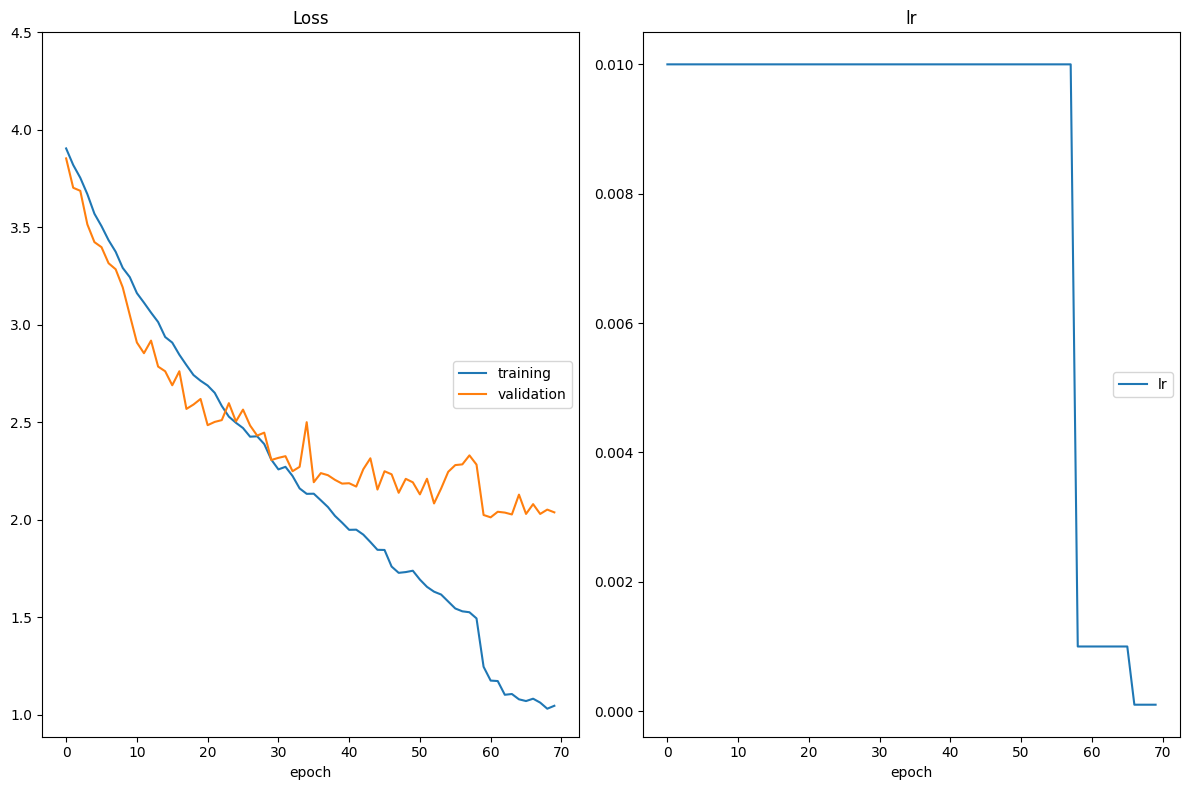

Validating: 100%|███████████████████████████████| 32/32 [00:01<00:00, 17.47it/s]

Epoch: 71 	Training Loss: 1.029700 	Validation Loss: 2.061793
EarlyStopping counter: 10 out of 10
Early stopping


In [2]:
from src.data import get_data_loaders
from src.train import optimize
from src.optimization import get_optimizer, get_loss
from src.model import MyModel

# get the data loaders using batch_size and valid_size defined in the previous
# cell
# HINT: do NOT copy/paste the values. Use the variables instead
data_loaders = get_data_loaders(batch_size=batch_size, valid_size=valid_size, num_workers=-1, limit=-1)
# YOUR CODE HERE

# instance model MyModel with num_classes and drouput defined in the previous
# cell
model = MyModel(num_classes=num_classes, dropout=dropout)
# YOUR CODE HERE

# Get the optimizer using get_optimizer and the model you just created, the learning rate,
# the optimizer and the weight decay specified in the previous cell
optimizer = get_optimizer(model,  optimizer = opt, learning_rate = learning_rate, weight_decay = weight_decay)
# YOUR CODE HERE

# Get the loss using get_loss
loss = get_loss()
# YOUR CODE HERE

optimize(
    data_loaders,
    model,
    optimizer,
    loss,
    n_epochs=num_epochs,
    save_path="checkpoints/best_val_loss.pt",
    interactive_tracking=True
)

In [3]:
# load the model that got the best validation accuracy
from src.train import one_epoch_test
from src.model import MyModel
import torch

model = MyModel(num_classes=num_classes, dropout=dropout)

# YOUR CODE HERE: load the weights in 'checkpoints/best_val_loss.pt'
model.load_state_dict(torch.load('checkpoints/best_val_loss.pt'))

# Run test
one_epoch_test(data_loaders['test'], model, loss)

Testing: 100%|██████████████████████████████████| 79/79 [00:04<00:00, 17.69it/s]

Test Loss: 2.187874


Test Accuracy: 53% (665/1250)


2.187874387713926

---
## <img src="static_images/icons/noun-advance-2109145.png" alt=">" style="width:50px"/> Step 7: Export using torchscript

Great job creating your CNN models! Now that you have put in all the hard work of creating accurate classifiers, let's export it so we can use it in our app.

But first, as usual, we need to complete some code!

Open `src/predictor.py` and fill up the missing code, then run the tests:

In [1]:
!pytest -vv src/predictor.py

============================= test session starts ==============================
platform linux -- Python 3.9.19, pytest-8.2.2, pluggy-1.5.0 -- /home/studio-lab-user/.conda/envs/default/bin/python3.9
cachedir: .pytest_cache
rootdir: /home/studio-lab-user/sagemaker-studiolab-notebooks/workspace/home/starter-kit
plugins: anyio-4.3.0
collected 1 item                                                               

src/predictor.py::test_model_construction PASSED                         [100%]

============================== 1 passed in 4.84s ===============================


Allright, now we are ready to export our model using our Predictor class:

In [2]:
# NOTE: you might need to restart the notebook before running this step
# If you get an error about RuntimeError: Can't redefine method: forward on class
# restart your notebook then execute only this cell
from src.predictor import Predictor
from src.helpers import compute_mean_and_std
from src.model import MyModel
from src.data import get_data_loaders
import torch

data_loaders = get_data_loaders(batch_size=1)

# First let's get the class names from our data loaders
class_names = data_loaders["train"].dataset.classes

# Then let's move the model_transfer to the CPU
# (we don't need GPU for inference)
model = MyModel(num_classes=50, dropout=0.5).cpu()

# Let's make sure we use the right weights by loading the
# best weights we have found during training
# NOTE: remember to use map_location='cpu' so the weights
# are loaded on the CPU (and not the GPU)

# YOUR CODE HERE
model.load_state_dict(torch.load("checkpoints/best_val_loss.pt", map_location="cpu"))

# Let's wrap our model using the predictor class
mean, std = compute_mean_and_std()
predictor = Predictor(model, class_names, mean, std).cpu()

# Export using torch.jit.script
scripted_predictor = torch.jit.script(predictor)
# YOUR CODE HERE

scripted_predictor.save("checkpoints/model_exported.pt")

Reusing cached mean and std
Dataset mean: tensor([0.4638, 0.4725, 0.4687]), std: tensor([0.2697, 0.2706, 0.3017])
Reusing cached mean and std


Now let's make sure the exported model has the same performance as the original one, by reloading it and testing it. The Predictor class takes different inputs than the non-wrapped model, so we have to use a specific test loop:

In [3]:
import torch

# Load using torch.jit.load
model_reloaded = torch.jit.load("checkpoints/model_exported.pt")

In [4]:
from src.predictor import predictor_test

pred, truth = predictor_test(data_loaders['test'], model_reloaded)

100%|███████████████████████████████████████| 1250/1250 [00:33<00:00, 37.56it/s]

Accuracy: 0.532


Finally, let's have a look at the confusion matrix of the model we are going to use in production:

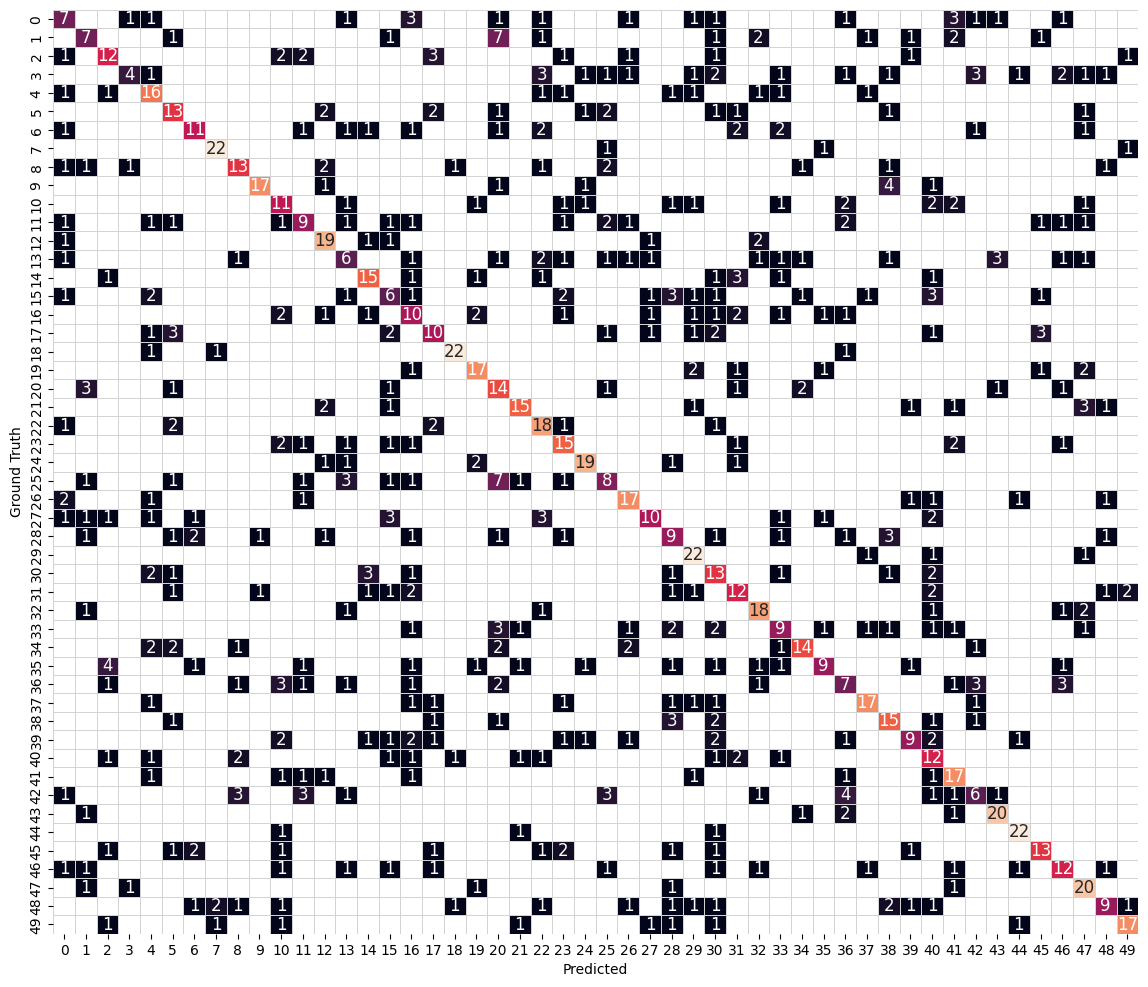

In [5]:
from src.helpers import plot_confusion_matrix

plot_confusion_matrix(pred, truth)